In [1]:
import xarray as xr
from glob import glob
from datetime import datetime
import yaml
import os

import plotting

try:
    from ecco_pipeline.conf.global_settings import GRIDS, OUTPUT_DIR
    from ecco_pipeline.utils.file_utils import get_date
    import ecco_pipeline.transformations.transformation as Transformation
except:
    os.chdir(os.path.realpath(os.path.join(os.path.abspath(''), '../../..')))
    from ecco_pipeline.conf.global_settings import GRIDS, OUTPUT_DIR
    from ecco_pipeline.utils.file_utils import get_date
    import ecco_pipeline.transformations.transformation as Transformation

In [2]:
ds_name = "SSMIS_OSI-401-b"
hemisphere = 'nh'
with open(f'conf/ds_configs/{ds_name}.yaml', 'r') as stream:
    config = yaml.load(stream, yaml.Loader)

# Load sample granule

In [3]:
ds_granules_dir = f'{OUTPUT_DIR}/{ds_name}/harvested_granules/'
ds_granules = glob(f'{ds_granules_dir}/**/*.nc*')
if hemisphere:
    ds_granules = [g for g in ds_granules if hemisphere in g]
sample_granule_path = ds_granules[0]
print(sample_granule_path)

/Users/marlis/Developer/ECCO/ecco_output/SSMIS_OSI-401-b/harvested_granules/2020/ice_conc_nh_polstere-100_multi_202001131200.nc


In [4]:
filename_date_str = get_date(config['filename_date_regex'], sample_granule_path.split('/')[-1])
granule_date = datetime.strptime(filename_date_str, config['filename_date_fmt']).strftime('%Y-%m-%dT%H:%M:%SZ')
ds = xr.open_dataset(sample_granule_path)
ds

<xarray.Dataset>
Dimensions:                   (time: 1, nv: 2, xc: 760, yc: 1120)
Coordinates:
  * time                      (time) datetime64[ns] 2020-01-13T12:00:00
  * xc                        (xc) float64 -3.845e+03 -3.835e+03 ... 3.745e+03
  * yc                        (yc) float64 5.845e+03 5.835e+03 ... -5.345e+03
    lat                       (yc, xc) float32 ...
    lon                       (yc, xc) float32 ...
Dimensions without coordinates: nv
Data variables:
    Polar_Stereographic_Grid  int32 ...
    time_bnds                 (time, nv) datetime64[ns] ...
    ice_conc                  (time, yc, xc) float32 ...
    ice_conc_unfiltered       (time, yc, xc) float32 ...
    masks                     (time, yc, xc) float32 ...
    confidence_level          (time, yc, xc) float32 ...
    status_flag               (time, yc, xc) float32 ...
    total_uncertainty         (time, yc, xc) float32 ...
    smearing_uncertainty      (time, yc, xc) float32 ...
    algorithm_uncertainty     (time, yc, xc) float32 ...
Attributes: (12/30)
    title:                   Daily Sea Ice Concentration Analysis from OSI SA...
    product_id:              OSI-401
    product_name:            osi_saf_ice_conc
    product_status:          operational
    abstract:                The daily analysis of sea ice concentration is o...
    topiccategory:           Oceans Climatology Meteorology Atmosphere
    ...                      ...
    references:              Product User Manual for OSI SAF Global Sea Ice C...
    history:                 2020-01-14 creation
    product_version:         4.0
    software_version:        1.3
    netcdf_version:          3.6.3
    Conventions:             CF-1.6

# Load grid

In [5]:
grids = glob(f'grids/*.nc*')
grids.sort()
f'Available grids: {grids}'

"Available grids: ['grids/ECCO_llc270.nc', 'grids/ECCO_llc90.nc', 'grids/grid_tpose6_radius.nc', 'grids/polar_stereo_n_25km.nc']"

In [6]:
grid_ds = xr.open_dataset(grids[1])
grid_ds

<xarray.Dataset>
Dimensions:                (tile: 13, j: 90, i: 90)
Coordinates:
  * tile                   (tile) int16 0 1 2 3 4 5 6 7 8 9 10 11 12
  * j                      (j) int16 0 1 2 3 4 5 6 7 ... 82 83 84 85 86 87 88 89
  * i                      (i) int16 0 1 2 3 4 5 6 7 ... 82 83 84 85 86 87 88 89
Data variables:
    XC                     (tile, j, i) float32 ...
    YC                     (tile, j, i) float32 ...
    effective_grid_radius  (tile, j, i) float32 ...
Attributes:
    name:                  ECCO_llc90
    type:                  llc
    geospatial_lat_min:    -89.873055
    geospatial_lat_max:    89.739395
    geospatial_lon_min:    -179.98895
    geospatial_lon_max:    179.98691
    geospatial_lat_units:  degrees_north
    geospatial_lon_units:  degrees_east

In [7]:
T = Transformation.Transformation(config, sample_granule_path, granule_date)

# Make mapping factors

In [8]:
factors = T.make_factors(grid_ds)

/Users/marlis/opt/anaconda3/envs/ecco_pipeline/lib/python3.10/site-packages/pyproj/crs/crs.py:1286: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


Only using 100 nearest neighbours, but you may need up to 181075038


/Users/marlis/opt/anaconda3/envs/ecco_pipeline/lib/python3.10/site-packages/pyresample/kd_tree.py:384: UserWarning: Possible more than 100 neighbours within 77123 m for some data points
  warnings.warn(('Possible more than %s neighbours '


0 %
5 %
10 %
15 %
21 %
26 %
31 %
36 %
42 %
47 %
52 %
57 %
63 %
68 %
73 %
78 %
84 %
89 %
94 %


# Transformation

In [9]:
field_ds_list = T.transform(grid_ds, factors, ds, config)

In [10]:
field_ds = field_ds_list[0][0]
field_ds

<xarray.Dataset>
Dimensions:                              (time: 1, tile: 13, j: 90, i: 90, nv: 2)
Coordinates:
  * time                                 (time) datetime64[ns] 2020-01-12T12:...
  * tile                                 (tile) int16 0 1 2 3 4 ... 8 9 10 11 12
  * j                                    (j) int16 0 1 2 3 4 ... 85 86 87 88 89
  * i                                    (i) int16 0 1 2 3 4 ... 85 86 87 88 89
    XC                                   (tile, j, i) float32 -111.6 ... -111.9
    YC                                   (tile, j, i) float32 -88.24 ... -88.1
    time_bnds                            (time, nv) datetime64[ns] 2020-01-12...
Dimensions without coordinates: nv
Data variables:
    ice_conc_interpolated_to_ECCO_llc90  (time, tile, j, i) float64 9.969e+36...
Attributes:
    interpolated_grid:            ECCO_llc90
    model_grid_type:              llc
    original_dataset_title:       Global Sea Ice Concentration (SSMIS)
    original_dataset_short_name:  Global Sea Ice Concentration (SSMIS)
    original_dataset_url:         https://osi-saf.eumetsat.int/products/osi-4...
    original_dataset_reference:   https://osisaf-hl.met.no/sites/osisaf-hl.me...
    original_dataset_doi:         OSI-401-b
    interpolated_grid_id:         ECCO_llc90
    transformation_version:       1.7
    notes:

# Visualization

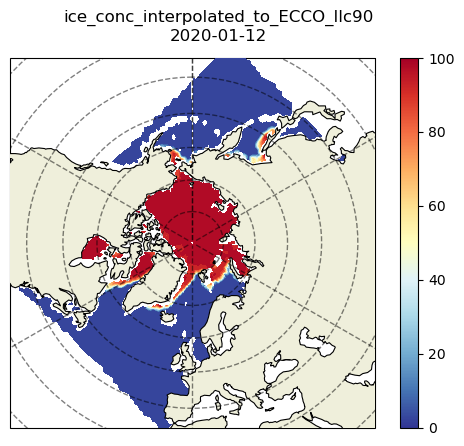

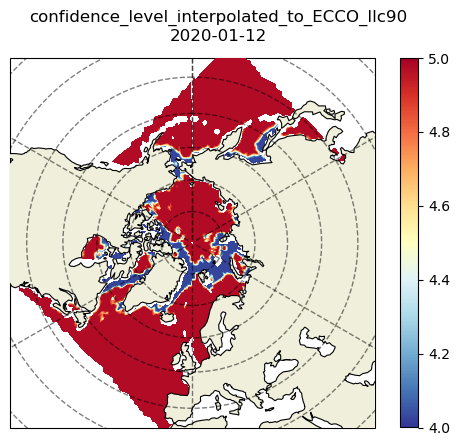

In [11]:
for field_ds in field_ds_list:
    plotting.make_plot(field_ds[0][list(field_ds[0].data_vars)[0]], 'nh')
